In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import set_config; set_config(display='diagram')

In [2]:
# Use this cell to regroup all your imports

from scipy import stats
import xarray as xr
# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

# Load data

## Train data

In [3]:
x = xr.open_dataset("X.nc")

In [4]:
X = x.to_array()[0]

In [5]:
Y = xr.open_dataset("Y.nc")

In [6]:
y = Y.to_dataframe()

In [7]:
y = y['UCUR'].to_numpy()

## Test data

# Prepare data

## Build pipeline for preproc data

This pipeline is important to adjust the data to enter in the DL model.

We are applying two corrections:
- KNNImputer: to impute value when we have missing data. It will get the closest value to complete
- Standardcale: to use ML and DL models, we have to rescale all variables to the same scale. I choose Standard sclae, but it will depends on the hist distribuition of the variations (normal distribution and outliers)

(array([ 48., 144., 106.,  72.,  59.,  56.,  67.,  49.,  27.,  20.]),
 array([294.6000061 , 294.73620605, 294.87240601, 295.00860596,
        295.14480591, 295.28100586, 295.41720581, 295.55340576,
        295.68960571, 295.82580566, 295.96200562]),
 <BarContainer object of 10 artists>)

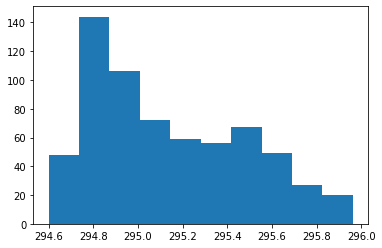

In [8]:
plt.hist(X[0][17:-1])

(array([3., 1., 0., 0., 0., 1., 1., 2., 3., 5.]),
 array([0.7934 , 0.80665, 0.8199 , 0.83315, 0.8464 , 0.85965, 0.8729 ,
        0.88615, 0.8994 , 0.91265, 0.9259 ]),
 <BarContainer object of 10 artists>)

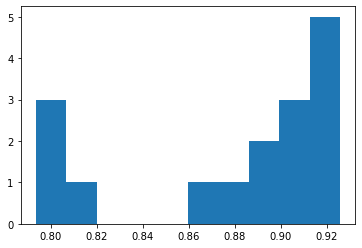

In [9]:
plt.hist(X[0][0:16])

In [10]:
def create_preproc(X):
    scaler = StandardScaler()

    return scaler

## Preproc data

Just to show the preproc model ⬇️

In [11]:
preproc = create_preproc(X)

Fit and transform the data ⬇️

In [12]:
preproc.fit(X)

StandardScaler()

# Machine Learning

In [14]:
pipe_baseline = make_pipeline(preproc, Ridge())
pipe_baseline

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [15]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
score_baseline

-86.64324113965301

In [ ]:
pipe_baseline.fit(X,y)
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline

# Deep Learning

## Preproc data

In [13]:
X_preproc = preproc.transform(X)

## Create validation split

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_preproc, y, test_size=0.3, random_state=0)

## Initialize model

See the shape of your data and try insert the number of columns in the input_dim value

In [17]:
X_train.shape

(24084, 666)

In [18]:
input_dim = 666 #insert here the number of dimensions of the X data

In [19]:
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_learning_rate = 0.01

lr = ExponentialDecay(
    initial_learning_rate, decay_steps=500, decay_rate=0.7,
)

def initialize_model(input_dim, lr):

    
    model = models.Sequential()

    opt = Adam(learning_rate=lr)
    
    model.add(layers.Dense(20, activation='relu', input_dim=input_dim))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer=opt,
                  loss='msle',
                  metrics='mae')# optimize for the squared log error!
    
    return model

Initialize modal and show its summary

In [20]:
model = initialize_model(input_dim, lr=0.001)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                13340     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 14,201
Trainable params: 14,201
Non-trainable params: 0
_________________________________________________________________


2021-08-06 04:22:31.837939: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fit model to your data

In [21]:
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=100,
                    batch_size=32, 
                    verbose=1, 
                    callbacks=[es])

2021-08-06 04:22:36.433746: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-06 04:22:36.434393: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz


Epoch 1/100
527/527 [==============================] - 2s 3ms/step - loss: 0.8912 - mae: 6.8130 - val_loss: 0.4893 - val_mae: 5.7199
Epoch 2/100
527/527 [==============================] - 1s 2ms/step - loss: 0.4897 - mae: 5.7054 - val_loss: 0.4382 - val_mae: 5.4828
Epoch 3/100
527/527 [==============================] - 1s 2ms/step - loss: 0.4255 - mae: 5.5466 - val_loss: 0.4863 - val_mae: 5.6071
Epoch 4/100
527/527 [==============================] - 1s 2ms/step - loss: 0.4213 - mae: 5.4673 - val_loss: 0.3698 - val_mae: 5.1427
Epoch 5/100
527/527 [==============================] - 1s 2ms/step - loss: 0.3914 - mae: 5.3145 - val_loss: 0.3297 - val_mae: 5.0793
Epoch 6/100
527/527 [==============================] - 1s 2ms/step - loss: 0.3531 - mae: 5.1685 - val_loss: 0.4042 - val_mae: 5.2325
Epoch 7/100
527/527 [==============================] - 1s 2ms/step - loss: 0.3392 - mae: 5.0710 - val_loss: 0.2904 - val_mae: 4.9554
Epoch 8/100
527/527 [==============================] - 1s 2ms/step - 

## Evaluate the model

In [22]:
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('MSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

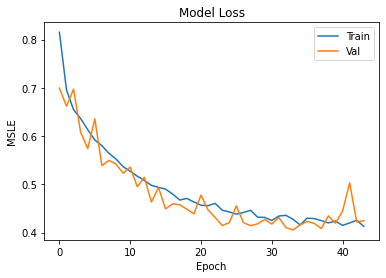

In [23]:
plot_history(history)

In [24]:
model.evaluate(X_val, y_val, verbose=0)

[0.16956084966659546, 4.294249057769775]

## Predict the data

In [25]:
y_pred = model.predict(preproc.transform(X))

In [35]:
preproc.transform(X)

array([[ 0.36687877,  0.77956846,  1.20926623, ..., -0.33372119,
        -0.29119868, -0.25563085],
       [ 0.36687877,  0.77956846,  1.20926623, ..., -0.33372119,
        -0.29119868, -0.25563085],
       [ 0.36687877,  0.77956846,  1.20926623, ..., -0.33372119,
        -0.29119868, -0.25563085],
       ...,
       [ 0.36488082,  0.20113471, -0.27822478, ..., -1.38196923,
        -1.44973773, -1.50321012],
       [ 0.36488082,  0.20113471, -0.27822478, ..., -1.38196923,
        -1.44973773, -1.50321012],
       [ 0.36488082,  0.20113471, -0.27822478, ..., -1.28972838,
        -1.36521329, -1.43161195]])

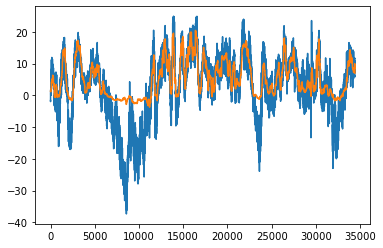

In [27]:
plt.plot(y)
plt.plot(y_pred)

## Predict Deep current u from 2002 to 2019

In [37]:
## Needs to match the first dimension
X_whole = xr.open_dataset('X_whole.nc').to_array()[0]

In [38]:
preproc.transform(X_whole)

array([[-0.93932311, -1.62223456, -1.91810429, ...,         nan,
                nan,         nan],
       [-0.91989977, -1.63680903, -1.9462874 , ...,         nan,
                nan,         nan],
       [-0.93243096, -1.65921051, -1.95771299, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ..., -0.63449625,
        -0.64276637, -0.65901387],
       [        nan,         nan,         nan, ..., -0.66779635,
        -0.66405501, -0.66922037],
       [        nan,         nan,         nan, ..., -0.70218719,
        -0.70954711, -0.72286439]])

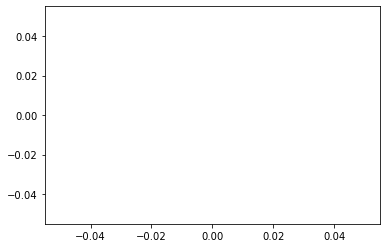

In [39]:
y_pred_whole = model.predict(preproc.transform(X_whole))
plt.plot(y_pred_whole)